# Highway ramp exploration
* How much data is there?
    * in district 11 for 2015 there are 1424 stations and 9.8 million records
* Is it available at 5 min intervals?
    * Data is available at 5 min intervals
* What percentage of the ramps have working sensors?
    * 66 stations of 1424 are broken
* Notes
    * Ramp sensors only keep track of Totalflow

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gzip
import time
from os import listdir
from os.path import isfile, join

/Users/multidest/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#data locations
data_5min_path = "../station_5min/2015/d11/"
meta_path = "../station_5min/2015/meta_data/d11/"

In [3]:
#get all files to process
onlyfiles = [f for f in listdir(data_5min_path) if isfile(join(data_5min_path, f))]

In [4]:
onlyfiles[0:3]

['d11_text_station_5min_2016_01_01.txt.gz',
 'd11_text_station_5min_2016_01_02.txt.gz',
 'd11_text_station_5min_2016_01_03.txt.gz']

In [5]:
colnames = ['Timestamp','Station','District','Freeway','Direction_of_Travel','LaneType','StationLength','Samples',
            'Perc_Observed','TotalFlow','AvgOccupancy','AvgSpeed',
            'Lane1_Samples','Lane1_Flow','Lane1_AvgOcc','Lane1_AvgSpeed','Lane1_Observed',
            'Lane2_Samples','Lane2_Flow','Lane2_AvgOcc','Lane2_AvgSpeed','Lane2_Observed',
            'Lane3_Samples','Lane3_Flow','Lane3_AvgOcc','Lane3_AvgSpeed','Lane3_Observed',
            'Lane4_Samples','Lane4_Flow','Lane4_AvgOcc','Lane4_AvgSpeed','Lane4_Observed',
            'Lane5_Samples','Lane5_Flow','Lane5_AvgOcc','Lane5_AvgSpeed','Lane5_Observed',
            'Lane6_Samples','Lane6_Flow','Lane6_AvgOcc','Lane6_AvgSpeed','Lane6_Observed',
            'Lane7_Samples','Lane7_Flow','Lane7_AvgOcc','Lane7_AvgSpeed','Lane7_Observed',
            'Lane8_Samples','Lane8_Flow','Lane8_AvgOcc','Lane8_AvgSpeed','Lane8_Observed',]

## Test on a single file first

In [6]:
#Extract contents of file and read to pandas dataframe
with gzip.open(data_5min_path+onlyfiles[0], 'rb') as f:
    file_content = pd.read_csv(f, header=None,names=colnames)

In [7]:
file_content.shape

(410112, 52)

In [8]:
file_content.head(3)

,Timestamp,Station,District,Freeway,Direction_of_Travel,LaneType,StationLength,Samples,Perc_Observed,TotalFlow,...,Lane7_Samples,Lane7_Flow,Lane7_AvgOcc,Lane7_AvgSpeed,Lane7_Observed,Lane8_Samples,Lane8_Flow,Lane8_AvgOcc,Lane8_AvgSpeed,Lane8_Observed
0,01/01/2016 00:00:00,1100313,11,5,N,FR,NaN,10,100,8.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,01/01/2016 00:00:00,1100323,11,5,N,FR,NaN,20,0,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,01/01/2016 00:00:00,1100326,11,5,N,FR,NaN,20,100,12.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [46]:
reset_selective file_content

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [47]:
#find all on ramps

def get_on_ramps(file_content):
    ramps = file_content.loc[file_content['LaneType']=='OR',:]

    interested_columns = ['Timestamp', 'Station', 'District', 'Freeway',
                          'Direction_of_Travel', 'LaneType', 'Samples',
                          'Perc_Observed', 'TotalFlow']
    
    print "good measure:",ramps.loc[:,'TotalFlow'].notnull().sum(), "total:", len(ramps)
    return ramps.loc[ramps.loc[:,'TotalFlow'].notnull(), interested_columns]


def get_off_ramps(file_content):
    ramps = file_content.loc[file_content['LaneType']=='FR',:]

    interested_columns = ['Timestamp', 'Station', 'District', 'Freeway',
                          'Direction_of_Travel', 'LaneType', 'Samples',
                          'Perc_Observed', 'TotalFlow']
    
    print "good measure:",ramps.loc[:,'TotalFlow'].notnull().sum(), "total:",len(ramps)
    return ramps.loc[ramps.loc[:,'TotalFlow'].notnull(), interested_columns]

def get_bad_sensors(file_content, columns):
    file_content['bad_count'] = file_content.loc[:,columns].isnull().sum(axis=1)
    total_bad = file_content.groupby('Station')['bad_count'].sum().reset_index()
    bad_stations = total_bad[total_bad['bad_count'] > 0]['Station'].tolist()
    #file_content['bad_station'] = file_content['Station'].isin(bad_stations) 
    return bad_stations

def get_sensors(file_content):
    return file_content.loc[:,'Station'].unique()

print get_on_ramps(file_content).head(3)
print get_off_ramps(file_content).head(3)

print len(get_bad_sensors(file_content,['TotalFlow']))
print len(get_sensors(file_content))

NameError: name 'file_content' is not defined

## Combine all files into one dataframe

In [10]:
df_list = []
for i, filename in enumerate(onlyfiles):
    t1 = time.time()
    with gzip.open(data_5min_path+filename, 'rb') as f:
        file_content = pd.read_csv(f,header=None,names=colnames)
        df_list.append(file_content)
    t2 = time.time()
    print i, filename, t2-t1
    
big_df = pd.concat(df_list)

0 d11_text_station_5min_2016_01_01.txt.gz 2.58869314194
1 d11_text_station_5min_2016_01_02.txt.gz 2.21782898903
2 d11_text_station_5min_2016_01_03.txt.gz 2.47034907341
3 d11_text_station_5min_2016_01_04.txt.gz 2.16082787514
4 d11_text_station_5min_2016_01_05.txt.gz 1.95682287216
5 d11_text_station_5min_2016_01_06.txt.gz 1.88166880608
6 d11_text_station_5min_2016_01_07.txt.gz 1.86313199997
7 d11_text_station_5min_2016_01_08.txt.gz 1.82492899895
8 d11_text_station_5min_2016_01_09.txt.gz 1.85870718956
9 d11_text_station_5min_2016_01_10.txt.gz 2.32379984856
10 d11_text_station_5min_2016_01_11.txt.gz 1.91515898705
11 d11_text_station_5min_2016_01_12.txt.gz 2.1928319931
12 d11_text_station_5min_2016_01_15.txt.gz 1.97640395164
13 d11_text_station_5min_2016_01_16.txt.gz 1.96315288544
14 d11_text_station_5min_2016_01_17.txt.gz 1.91680908203
15 d11_text_station_5min_2016_01_18.txt.gz 1.96302485466
16 d11_text_station_5min_2016_01_19.txt.gz 1.94761395454
17 d11_text_station_5min_2016_01_20.txt.gz

In [40]:
big_df.shape

(9842688, 53)

In [41]:
big_df.head(3)

,Timestamp,Station,District,Freeway,Direction_of_Travel,LaneType,StationLength,Samples,Perc_Observed,TotalFlow,...,Lane7_Flow,Lane7_AvgOcc,Lane7_AvgSpeed,Lane7_Observed,Lane8_Samples,Lane8_Flow,Lane8_AvgOcc,Lane8_AvgSpeed,Lane8_Observed,bad_count
0,01/01/2016 00:00:00,1100313,11,5,N,FR,NaN,10,100,8.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0
1,01/01/2016 00:00:00,1100323,11,5,N,FR,NaN,20,0,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1
2,01/01/2016 00:00:00,1100326,11,5,N,FR,NaN,20,100,12.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0


In [42]:
big_df['LaneType'].describe()
big_df.groupby(['LaneType'])['Station'].unique().apply(lambda x:len(x))

LaneType
CD      1
CH      7
FF     47
FR    229
HV     87
ML    746
OR    307
Name: Station, dtype: int64

In [56]:
on_ramps = get_on_ramps(big_df)
off_ramps = get_off_ramps(big_df)

good measure: 1928051 total: 2121984
good measure: 1267668 total: 1582848


In [71]:
#count bad stations
bad_stations = get_bad_sensors(on_ramps,['TotalFlow'])
sensors = get_sensors(on_ramps)

print len(bad_stations)
print len(sensors)


#remove bad stations
on_ramps = on_ramps.loc[~(on_ramps['Station'].isin(bad_stations)),:]

my_list = on_ramps.head(3).loc[:,'Station'].tolist()

0
303


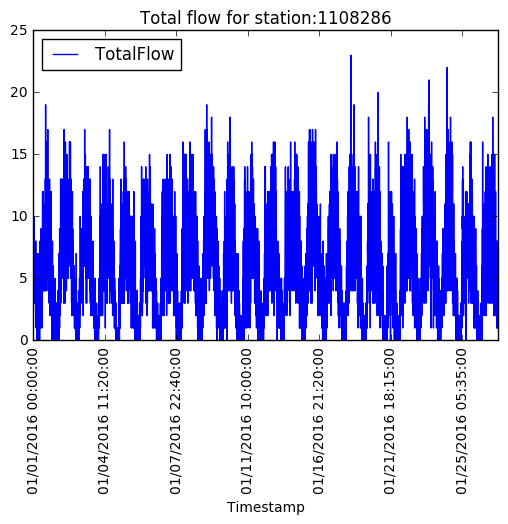

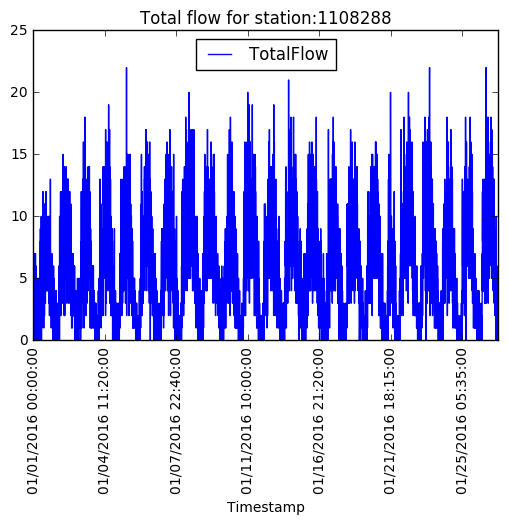

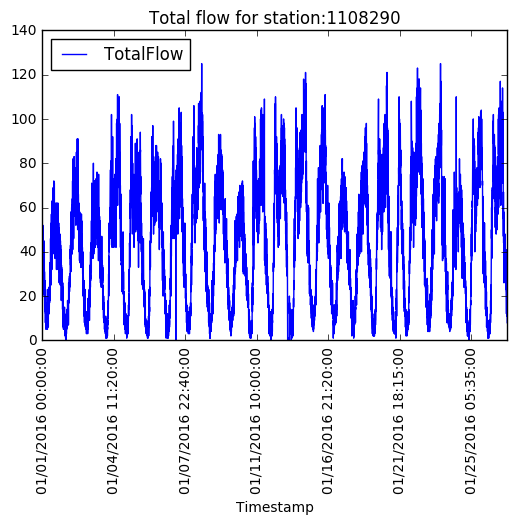

In [72]:
stations_grouped = on_ramps.groupby('Station')
for station in my_list:
    small_df = stations_grouped.get_group(station).loc[:,['Timestamp','TotalFlow']]
    small_df.loc[:,:].plot(x='Timestamp', y='TotalFlow', title="Total flow for station:%i"%(station),rot=90)

In [73]:
#count bad off ramptsstations
bad_stations = get_bad_sensors(off_ramps,['TotalFlow'])
sensors = get_sensors(off_ramps)

print len(bad_stations)
print len(sensors)


#remove bad stations
off_ramps = off_ramps.loc[~(off_ramps['Station'].isin(bad_stations)),:]

my_list = off_ramps.head(3).loc[:,'Station'].tolist()

0
199


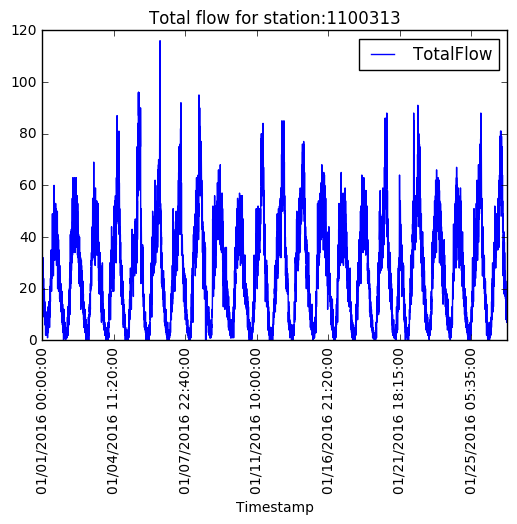

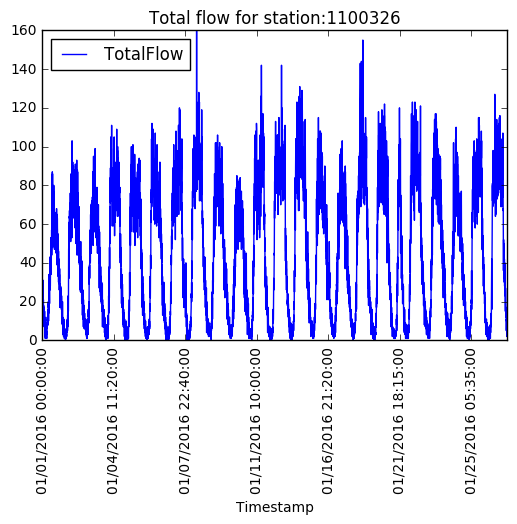

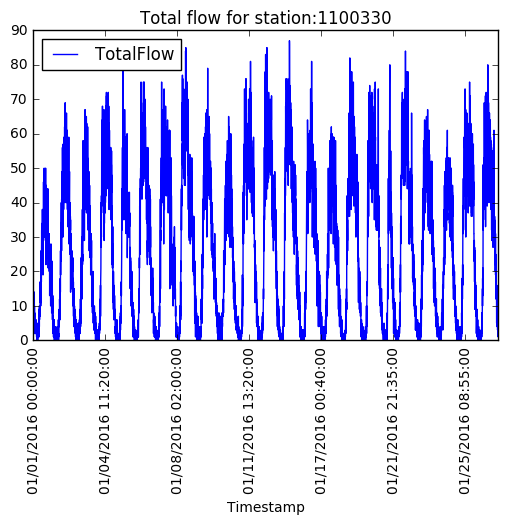

In [75]:
stations_grouped = off_ramps.groupby('Station')
for station in my_list:
    small_df = stations_grouped.get_group(station).loc[:,['Timestamp','TotalFlow']]
    small_df.loc[:,:].plot(x='Timestamp', y='TotalFlow', title="Total flow for station:%i"%(station),rot=90)